In [1]:
from __future__ import print_function
import numpy as np
from scipy.io import loadmat
import os
import glob
from six.moves import cPickle as pickle

import matplotlib.pyplot as plt
%matplotlib inline

print("import done")

import done


#### Create Datasets by randomly mixing 10min segments of preictal and interictal data.

In [11]:
def clean_normalize_data(data, sigma=1.0):
    data_tmp = list()
    for d in data:
        if (np.count_nonzero(d) < 10) or (np.any(np.std(d, axis=0) < sigma)):
            continue
        # Normalize mean=0 and sigma=0.5: axis = 0 is along columns, vertical lines.
        d -= np.mean(d, axis=0) 
        d /= np.ptp(d, axis=0)
        data_tmp.append(d)
    return np.asarray(data_tmp)    

Converting files ./data/train_1/1_82_1.mat to ./data/train_1/1_78_1.mat
Converting files ./data/train_1/1_97_0.mat to ./data/train_1/1_509_0.mat
Merging preictal and interictal data..
(27, 240000, 16)
Pickling to ./data/trainsh1.pickle
dataset done


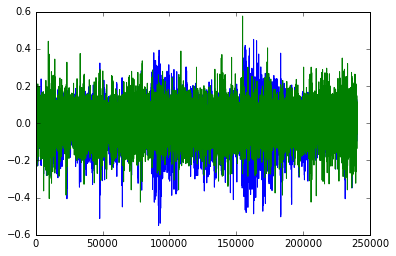

In [12]:
#convert .mat data into ndarray and compress it usingle pickle
def mat_to_numpy(files):
    print('Converting files ' + files[0] + ' to ' + files[-1])
    data = list()
    for idx, fl in enumerate(files):
        #open mat file
        mat = loadmat(fl)
        #convert from ndarray object to ndarray
        names = mat['dataStruct'].dtype.names
        ndata = {n: mat['dataStruct'][n][0, 0] for n in names}
        #detect if columns out of order
        if not all(x<y for x, y in zip(ndata['channelIndices'][0], ndata['channelIndices'][0][1:])):
            print('WARNING: Columns out of order in file' + fl)
        # Clean and normalize data
        data.append(ndata['data'])
    data = clean_normalize_data(data)
    return data

nrOfFiles = 15

def dataset(folder, name_pickle):
    #get files
    files_preictal = glob.glob(folder + "/*1.mat")
    files_interictal = glob.glob(folder + "/*0.mat")
    #randomize read files
    np.random.shuffle(files_preictal)
    np.random.shuffle(files_interictal)
    #read files into ndarrays
    data_preictal = mat_to_numpy(files_preictal[:nrOfFiles])
    labels_preictal = np.ones(data_preictal.shape[0], dtype=np.int32)
    data_interictal = mat_to_numpy(files_interictal[:nrOfFiles])
    labels_interictal = np.zeros(data_interictal.shape[0], dtype=np.int32)
    #concatenate preictal and interictal data
    print('Merging preictal and interictal data..')
    data_merge = np.concatenate((data_preictal, data_interictal), axis=0)
    labels_merge = np.concatenate((labels_preictal, labels_interictal), axis=0)
    #bundle data and labels in dictionary
    print(data_merge.shape)
    save = {'data': data_merge, 'labels': labels_merge}
    try:
        with open(name_pickle, 'wb') as f:
            print('Pickling to ' + name_pickle)
            pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    except Exception as e:
        print('Unable to save data to' + name_pickle + ' :', e)
    
dataset('./data/train_1', './data/trainsh1.pickle')

print('dataset done')